In [1]:
!pip install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 732.5 kB/s eta 0:00:0000:0100:02


In [1]:
from casadi import *
from matplotlib.pyplot import plot, show

x = MX.sym('x',2)  # Two states
p = MX.sym('p')    # Free parameter

# Expression for ODE right-hand side
z = 1-x[1]**2;
rhs = vertcat(z*x[0]-x[1]+2*tanh(p),x[0])




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      200
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5050

Total number of variables............................:      100
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality c

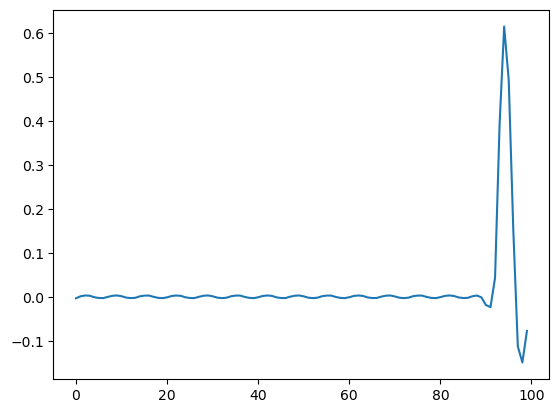

In [2]:

# ODE declaration with free parameter
ode = {'x':x,'p':p,'ode':rhs}

# Construct a Function that integrates over 1s
F = integrator('F','cvodes',ode,0,1)

num_steps=100
# Control vector
u = MX.sym('u',num_steps,1)

x = [0,1]  # Initial state
for k in range(num_steps):
  # Integrate 1s forward in time:
  # call integrator symbolically
  res = F(x0=x,p=u[k])
  x = res['xf']


# NLP declaration
nlp = {'x':u,'f':dot(u,u),'g':x}

# Solve using IPOPT
solver = nlpsol('solver','ipopt',nlp)
res = solver(x0=0.2,lbg=0,ubg=0)

plot(res['x'])
show()

In [2]:
import casadi as ca
import numpy as np

"""
In this Python code, we use CasADi to model a smooth version of the PIVO ODE system, 
similarly to how you'd do it with a CasADi integrator-based approach and an NLP solver. 
The objective is to maximize profit (or minimize negative profit) subject to 
budget >= 0 and a penalty on strategy changes.
We do a direct single-shooting-like method by discretizing time and controls, 
and we embed the ODE integration into an NLP problem.

NOTE: This is a schematic example; feel free to adapt for real usage.
"""


"\nIn this Python code, we use CasADi to model a smooth version of the PIVO ODE system, \nsimilarly to how you'd do it with a CasADi integrator-based approach and an NLP solver. \nThe objective is to maximize profit (or minimize negative profit) subject to \nbudget >= 0 and a penalty on strategy changes.\nWe do a direct single-shooting-like method by discretizing time and controls, \nand we embed the ODE integration into an NLP problem.\n\nNOTE: This is a schematic example; feel free to adapt for real usage.\n"

In [3]:

###############################################################################
# 1) Define the ODE system as a CasADi function
###############################################################################

def make_pivo_ode(x, p):
    """
    Inputs:
      x = [product, nEverTried, totalLost, accumPnL, valueAdded, budget]
      p is a dict with parameters, but here we pass them as arguments
      plus the piecewise-constant control array 'controls'
      We'll look up the correct "s" for the current time in single-shooting

    Returns dxdt symbolic expression (6x1).
    """
    product            = x[0]
    nCustEverTried     = x[1]
    totalLost          = x[2]
    accumPnL           = x[3]
    valAdded           = x[4]
    budg               = x[5]

    # parameters
    prodAdvRate        = p["prodAdvRate"]
    marketCap          = p["marketCap"]
    churnProb          = p["churnProb"]
    initWorkGen        = p["initWorkGen"]
    recurringWork      = p["recurringWork"]
    repMult            = p["repMult"]
    salary             = p["salary"]
    recurringFee       = p["recFee"]
    onboardFee         = p["onboardFee"]
    prodCap            = p["prodCap"]
    compRate           = p["compRate"]
    acquireSpeed       = p["acquireSpeed"]
    wStrategyChange    = p["wStrat"]
    wBudgetPenalty     = p["wBudg"]
    # For continuous-time, we'll pass "control" as a parameter: s
    s_t                = p["control"]  # a single scalar for this step
    # NOTE: We'll do single-shooting: we'll feed the appropriate s(t) 
    # in each sub-interval.

    # smooth logistic
    def σ(zz):
        return 1.0/(1.0 + ca.exp(-zz))

    # fraction
    wP = σ(s_t)
    wC = 1.0 - wP

    totalCurCust = nCustEverTried - totalLost
    smallEps = 1e-2

    # reputation
    # rep = repMult + (1 - repMult)*(totalCurCust)/(nCustEverTried + smallEps)
    rep = repMult + (1. - repMult)*(totalCurCust)/(nCustEverTried + smallEps)

    # cost to acquire
    costAcquireMult = 0.4
    costAcquire = costAcquireMult*σ( -0.5*(totalCurCust - 4.) )

    # ODE expressions
    # 1) d(product)/dt
    wC2P = 0.15
    dproduct = prodAdvRate*(1. - product)*( wP + wC2P*wC )

    # 2) new customers
    gainCust = acquireSpeed*rep*(marketCap - nCustEverTried)*product
    losePot  = compRate*(marketCap - nCustEverTried)
    dnEver   = gainCust - losePot
    # clamp if negative & none left
    dnEver_clamped = ca.fmax(dnEver, -nCustEverTried)

    # 3) currentWork by customers
    curWork = initWorkGen*gainCust + recurringWork*totalCurCust

    # 4) d(valueAdded)/dt
    denom_smooth = (1. - product) + (1./prodCap)
    dval = (product / denom_smooth)*wC

    # 5) churn
    unmet = (curWork - dval)
    churnRate = churnProb*ca.fmax(0., unmet)
    dLost = churnRate

    # 6) accumPnL
    signups = ca.fmax(gainCust,0.)
    dPnL = onboardFee*signups - costAcquire*salary*signups \
           + recurringFee*totalCurCust - salary*(wP + wC)

    # 7) budget usage 
    netCost = costAcquire*salary*signups + salary*(wP + wC)
    dbudget = - netCost  # for simplicity

    return ca.vertcat(dproduct, dnEver_clamped, dLost, dPnL, dval, dbudget)


In [4]:

###############################################################################
# 2) Set up the single-shooting approach with piecewise controls
###############################################################################

Nsteps = 30    # number of time steps
tf     = 30.0  # final time
dt     = tf/Nsteps


In [5]:

# We'll create a symbolic variable for the control at each step
controls = ca.SX.sym('controls', Nsteps)


In [6]:

# Make parameter dict for the ODE:
# We'll store them as 'normal' python floats or placeholders, 
# but in practice we feed them to integrator each step.
pvals = {
    "prodAdvRate": 0.1,
    "marketCap": 10.0,
    "churnProb": 0.8,
    "initWorkGen": 1.0,
    "recurringWork": 0.1,
    "repMult": 0.2,
    "salary": 2.0,
    "recFee": 0.3,
    "onboardFee": 30.0,
    "prodCap": 5.0,
    "compRate": 0.01,
    "acquireSpeed": 0.3,
    "wStrat": 0.1,   # penalty for strategy changes
    "wBudg": 100.0,  # penalty for budget dropping below 0
    "control": 0.0   # placeholder, replaced at each step
}


In [7]:

# initial state
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 50.0])


In [8]:

# Build an integrator in CasADi for a single step:
# We'll treat "control" as an extra parameter each time
x_sym = ca.SX.sym('x',6)
p_sym = ca.SX.sym('p',1)  # just hold the current control in p_sym[0]
# We'll create a big param-dict then fix p_sym[0] = controls[i] at run-time
# We do that by constructing an "ode" that depends on p_sym and we define
# the function using integrator with 'cvodes' or 'rk' method.

# We do it in a simpler way here by rewriting a small function each step:
pDictSym = dict(pvals)  # copy
pDictSym["control"] = p_sym[0]
dx_expr = make_pivo_ode(x_sym, pDictSym)


In [9]:

ode = {'x': x_sym, 'p': p_sym, 'ode': dx_expr}

F = ca.integrator('F','cvodes', ode, 
                  {'t0':0, 'tf':dt,
                   'abstol':1e-8, 'reltol':1e-8})

###############################################################################
# 3) Build the NLP with these integrator calls, stepping from 0..Nsteps
###############################################################################
opti = ca.Opti()


CasADi - 2024-12-21 18:37:21 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


In [10]:

# Our decision variables are the controls:
U = opti.variable(Nsteps)
# We'll also define xFinal if we need it, or we can just do the forward pass.


In [11]:

# propagate the ODE
Xk = x0
for i in range(Nsteps):
    # penalty for change in control
    if i>0:
        # (U[i] - U[i-1])^2
        pass
    # integrate one step
    res = F(x0=Xk, p=U[i])
    Xk = res["xf"]


In [12]:

# At the end, Xk is the final state. The final PnL is Xk[3].
finalPnL = Xk[3]

# We define a penalty for large changes in strategy:
sum_stratpen = 0
for i in range(Nsteps-1):
    sum_stratpen += (U[i+1] - U[i])**2


In [13]:

# We define a penalty for budget below 0 over the path:
# single-shooting approach => let's just sample it
# We can refine by e.g. partial timesteps. 
# For simplicity, let's do a quick pass again:
budget_neg_pen = 0
tmpX = x0
nsample = 3  # sample within each step?
dt_sub = dt/nsample
for i in range(Nsteps):
    for ss in range(nsample):
        # small step
        subres = F(x0=tmpX, p=U[i]) 
        xmid = subres["xf"]
        # penalty for negative budget:
        bval = xmid[5]
        budget_neg_pen += ca.fmax(0, -bval)
        tmpX = xmid


In [14]:

# objective is: - finalPnL + wStrat * sum_strat + wBudg * budget_neg_pen
wStrat = pvals["wStrat"]
wBudg  = pvals["wBudg"]
obj = -finalPnL + wStrat*sum_stratpen + wBudg*budget_neg_pen

opti.minimize(obj)


In [15]:

# constraints: we can also add a hard constraint that final budget >= 0:
opti.subject_to(Xk[5] >= 0)

# we can also clamp controls in [-2,2] for example:
for i in range(Nsteps):
    opti.subject_to(opti.bounded(-2.0, U[i], 2.0))

# initial guess
opti.set_initial(U, 0.0)


In [18]:

# solve
opti.solver('ipopt', 
    {"expand":True}, 
    {"max_iter":300, "print_level":3}
)

sol = opti.solve()


RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:165:
.../casadi/core/function_internal.cpp:147: Error calling IpoptInterface::init for 'solver':
Error in Function::call for 'nlp' [MXFunction] at .../casadi/core/function.cpp:370:
Error in Function::operator() for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1522:
.../casadi/core/function_internal.cpp:2024: 'eval_sx' not defined for CvodesInterface

In [17]:

U_star = sol.value(U)
print("Optimal controls = ", U_star)
print("Objective = ", sol.value(obj))

NameError: name 'sol' is not defined